In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1250]:
from time import time

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy import signal
import xrscipy.signal as dsp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

import gsw

from niwtools.tools import *
from niwtools.qc import *
from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [1251]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')

In [1252]:
# need to relax the qc criteria a bit because of heaving due to larger surface gravity waves
raw = qc_velocity(raw, RotPmax = 25, verrmax = 0.2)
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))

In [1253]:
if raw.z.max()>100:
    raw.coords['z'] = -raw.z

In [1254]:
raw = raw.sel(time=slice('2016-10-05','2016-10-19'))

In [1255]:
# bandpass between low*f and high*f
f = gsw.f(40.7)/(2*np.pi)
raw = bandpass_velocity(raw, 0.75*f, 1.25*f)

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:114: UnevenSamplingWarning: Average sampling 6.44e+03 != first sampling step 6.9e+03
  T = ( dsp.get_sampling_step(raw, dim='dtime') )


In [1256]:
raw['dudz'] = raw.u.differentiate('z',)
raw['dvdz'] = raw.v.differentiate('z')
raw['S'] = 0.5*(raw.dudz**2 + raw.dvdz**2)

raw['dudzNI'] = raw.uNI.differentiate('z')
raw['dvdzNI'] = raw.vNI.differentiate('z')
raw['SNI'] = 0.5*(raw.dudzNI**2 + raw.dvdzNI**2)

In [1422]:
def backrotate_phase(ang):
    ref_time = pd.to_datetime('1/1/2016')
    timestamp = pd.to_datetime(ang.time.values)
    Tf =2 * np.pi / gsw.f(40.7)
    dt = (timestamp - ref_time) / pd.to_timedelta(1, unit='s') % Tf
    phase_add = (dt.values * gsw.f(40.7)).astype('float')
    ang_br = ang + phase_add*180/np.pi
    
    return wrap(ang_br)

def backrotate_rc(phase0):
    f= gsw.f(40.7)
    ref_time = pd.to_datetime('1/1/2016')
    timestamp = pd.to_datetime(phase0.time.values)
    dt = (timestamp - ref_time) / pd.to_timedelta(1, unit='s')
    backrotate = np.arctan2(np.sin(f*dt.values),np.cos(f*dt.values))*180/np.pi
  
    return wrap(phase0 + backrotate)

def wrap(test, deg=True):
    if deg:
        phases = (( -test + 180) % (2.0 * 180 ) - 180) * -1.0
    else:
        phases = (( -test + np.pi) % (2.0 * np.pi ) - np.pi) * -1.0
    return phases

In [1423]:
raw['hkeNI'] = 0.5*( raw.uNI**2 + raw.vNI**2) # that gonna be in [m^2 s^{-2}]
raw['hkeTOT'] = 0.5*( raw.u**2 + raw.v**2)

In [1424]:
raw['ang'] =  ( ('z','time'),  np.angle(raw.uNI + 1j*raw.vNI, deg=True))
raw['angS'] =  ( ('z','time'), np.angle(raw.dudzNI + 1j*raw.dvdzNI, deg=True) )
raw['angS_br0'] = backrotate_phase(raw.angS)

In [1425]:
raw['ang_br0'] = backrotate_phase(raw.ang)
raw['rcs'] = backrotate_rc(raw.ang)

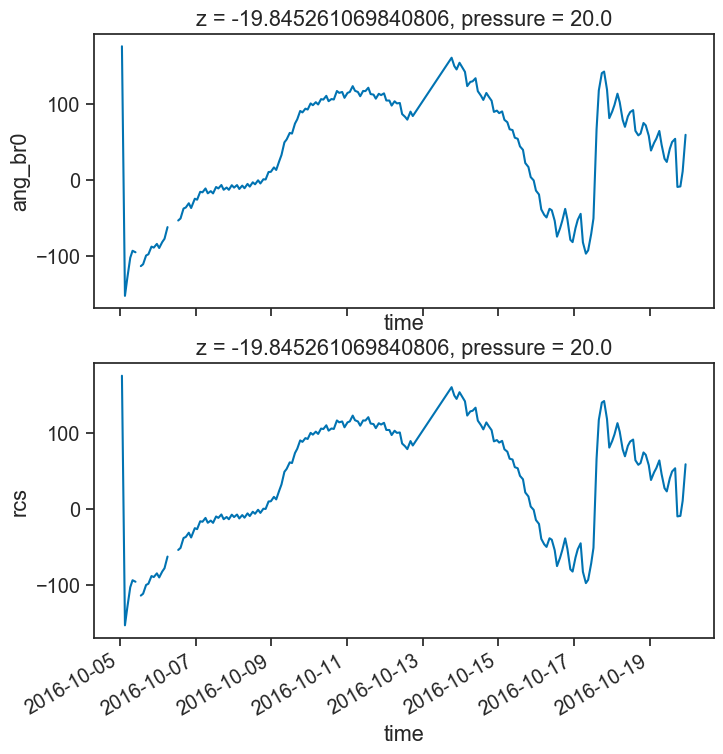

In [1426]:
f, ax = plt.subplots(2,1, figsize=(8,8), sharex=True)
raw.ang_br0.isel(z=10).plot(ax=ax[0])
raw.rcs.isel(z=10).plot(ax=ax[1])

(-500, 0)

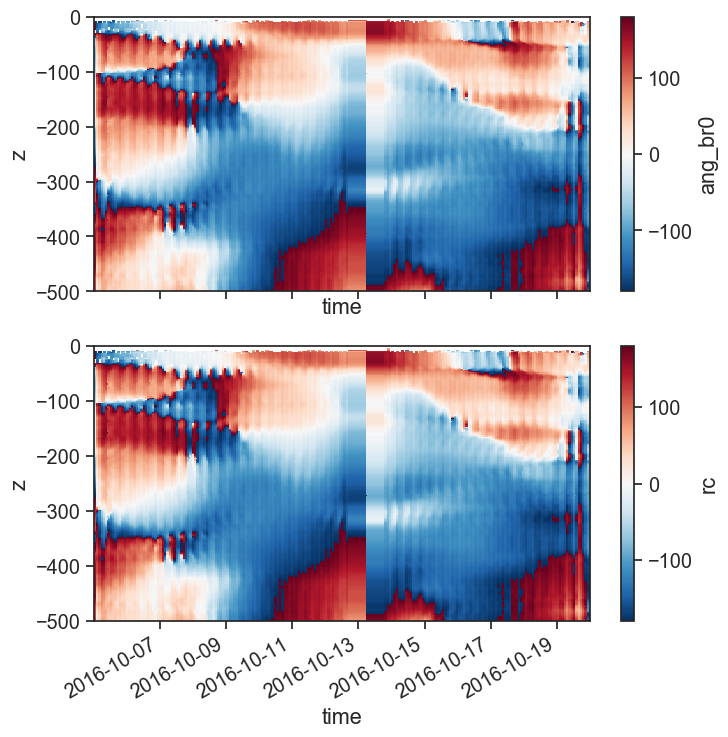

In [1427]:
f, ax = plt.subplots(2,1, figsize=(8,8), sharex=True)
raw.ang_br0.plot(ax=ax[0])
ax[0].set_ylim(-500,0)
raw.rcs.plot(ax=ax[1], cbar_kwargs={'label':'rc'})
ax[1].set_ylim(-500,0)

In [1363]:
def phase_cos(t, a, b,c):
    fi = gsw.f(40.3)
    return a * np.cos(b*t + c)

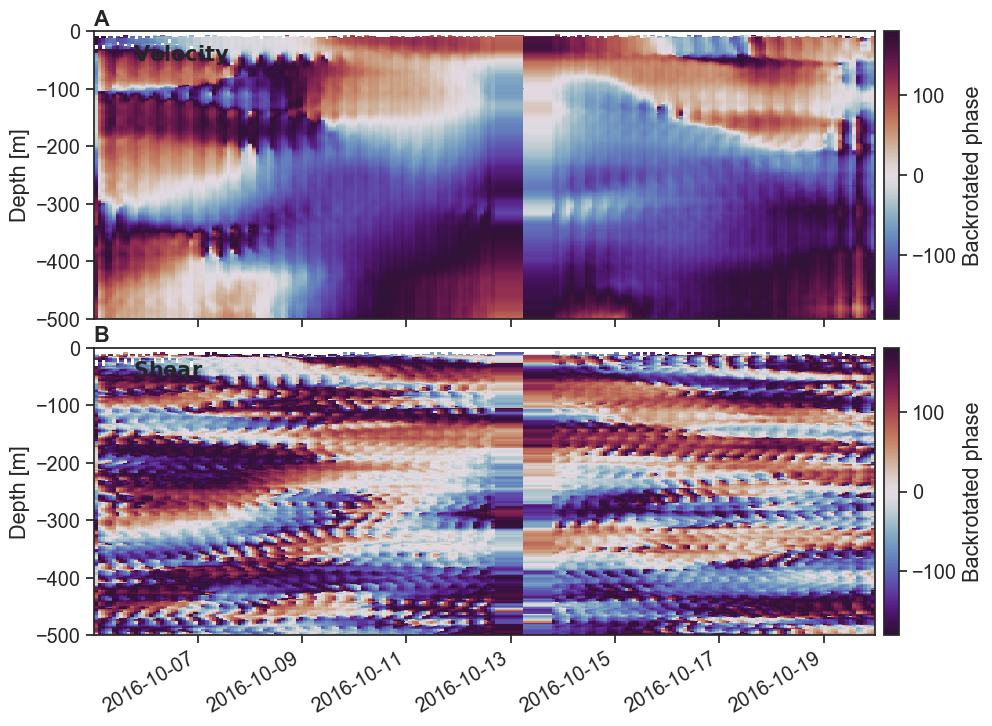

In [1364]:
mask = raw.hkeNI>0
zmin=-500
f, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

raw.ang_br0.where(mask).plot(ax=ax[0],cmap='twilight_shifted',cbar_kwargs={'label':'Backrotated phase', 'pad':0.01}, rasterized=True)
ax[0].set_ylim(zmin,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

text= r'$\mathbf{Velocity}$'
ax[0].annotate(text,(0.05,0.9), xycoords='axes fraction', fontsize=15)

raw.angS_br0.where(mask).plot(ax=ax[1],cmap='twilight_shifted',cbar_kwargs={'label':'Backrotated phase', 'pad':0.01}, rasterized=True)
ax[1].set_ylim(zmin,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

text= r'$\mathbf{Shear}$'
ax[1].annotate(text,(0.05,0.9), xycoords='axes fraction', fontsize=15)

f.subplots_adjust(hspace=0.1)
alphabet(ax)

# plt.savefig('../figures/phase_ryu.pdf')

In [1409]:
ml_mask = (raw.z<40) & (raw.z>0)
raw['ang_br_avg'] = raw.ang_br0.where(ml_mask).mean(dim='z')
raw['angS_br_avg'] = raw.angS_br0.where(ml_mask).mean(dim='z')
raw['hke_avg'] = raw.hkeNI.where(ml_mask).mean(dim='z')

$ \phi = \arctan{v/u} +ft $ 

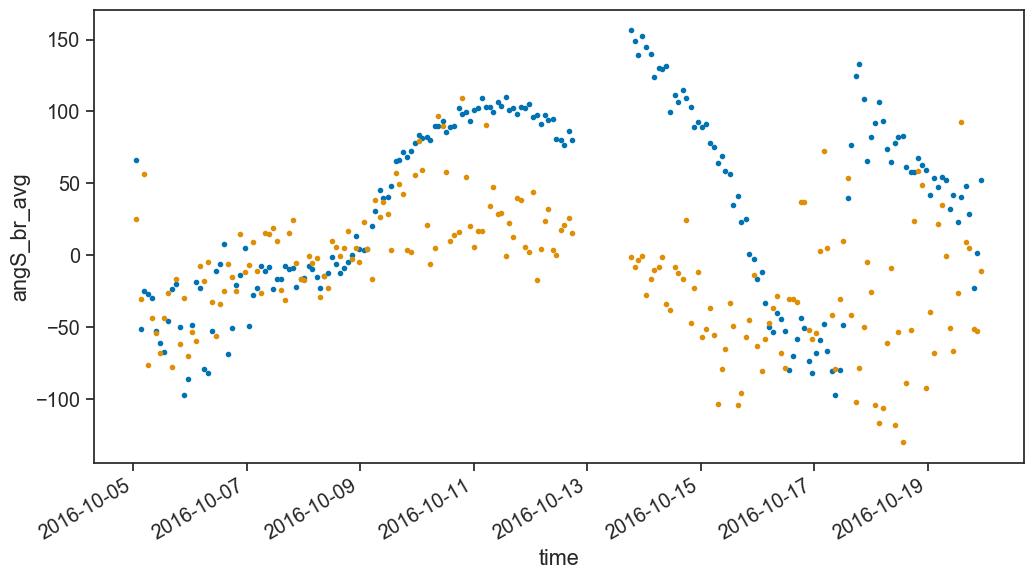

In [1410]:
raw['ang_br_avg'].plot(marker='.', lw=0)
raw['angS_br_avg'].plot(marker='.', lw=0)

### RC's phase plot and vertical scale
![rc_phase](rc_phase.png)

In [1371]:
raw = qc_turbulence(raw)

(-500, 0)

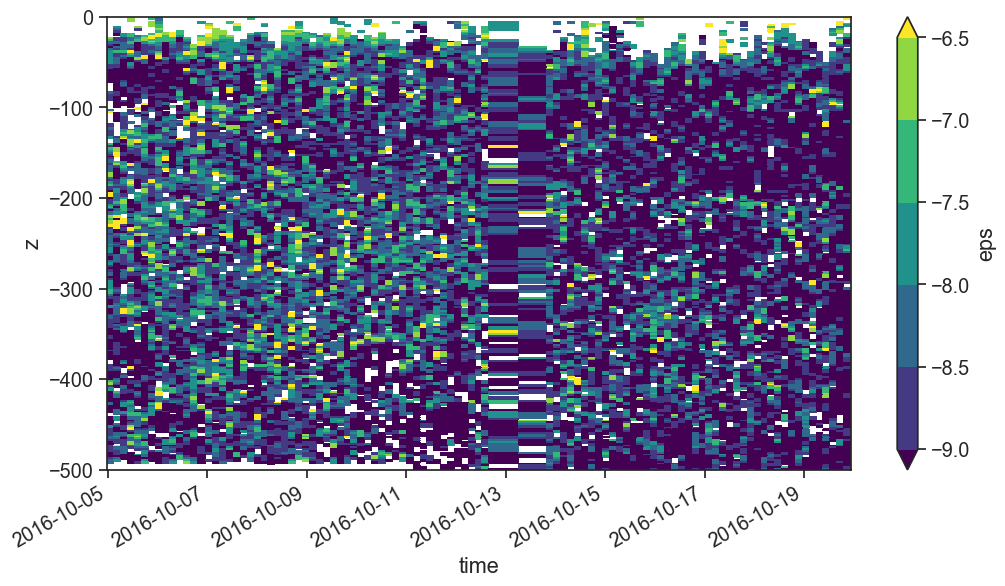

In [1372]:
raw.eps.dropna('time',how='all').pipe(np.log10).plot(levels=np.arange(-9,-6,0.5), cmap='viridis')
plt.ylim(-500,0)

In [1411]:
raw['kz_vel'] = raw.ang_br0.pipe(np.radians).differentiate('z').pipe(lambda x: x/(2*np.pi))

(-500, 0)

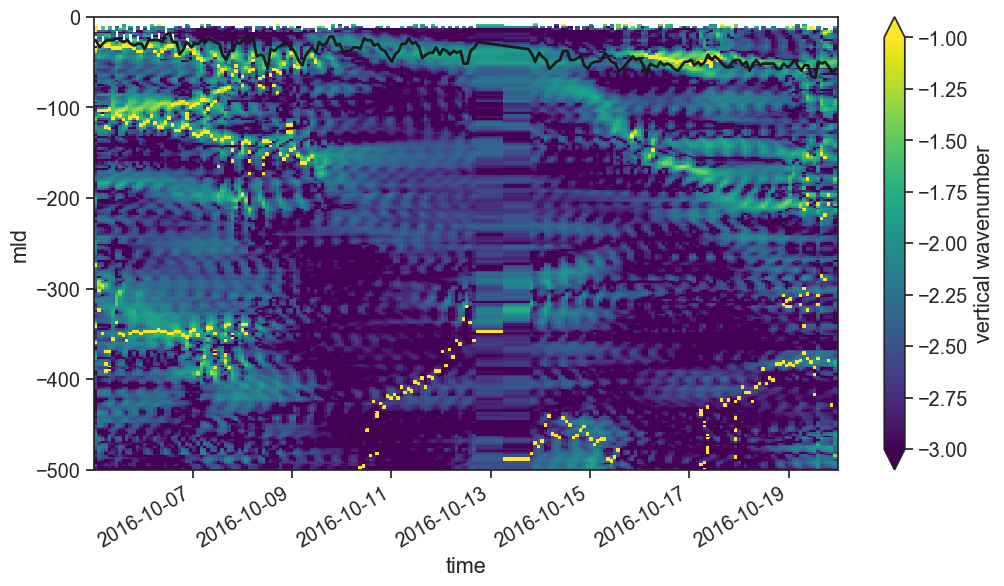

In [1428]:
raw.kz_vel.pipe(np.abs).pipe(np.log10).plot(
    vmin=-3, vmax=-1, cbar_kwargs={'label':'vertical wavenumber'})
raw.mld.plot(color='k', lw=2)
plt.ylim(-500,0)

In [1429]:
raw['kz_shear'] = raw.angS_br0.pipe(np.radians).differentiate('z').pipe(lambda x: x/(2*np.pi))

(-500, 0)

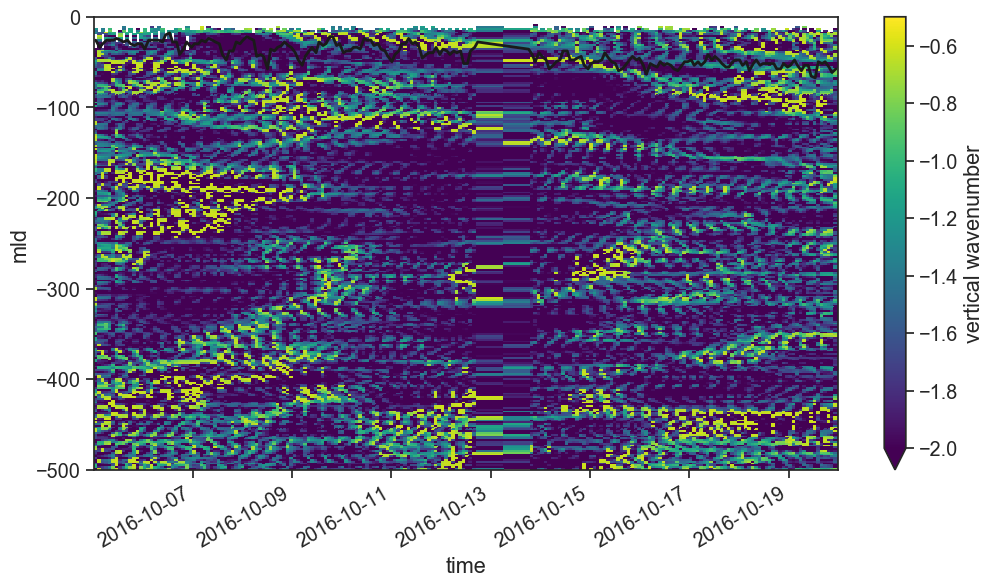

In [1430]:
raw.kz_shear.pipe(np.abs).pipe(np.log10).plot(vmin=-2, vmax=-0.5,
            cbar_kwargs={'label':'vertical wavenumber'})
raw.mld.plot(color='k', lw=2)
plt.ylim(-500,0)

In [1431]:
from xarrayutils.vertical_coordinates import linear_interpolation_regrid, linear_interpolation_remap

In [1432]:
def get_sigma_coodinates(data):
    ''' regrid data onto sigma
    '''
    data.coords['z'] = -data.z
    if data.sigma.mean()>50:
        data['sigma'] = data.sigma-1000
    data['sigma'] = xr.where(data.sigma<20, np.nan, data.sigma)
    rho_min = data.sigma.min()
    rho_max = data.sigma.max()
    sigma_vals = np.arange(rho_min,rho_max, 0.01)
    sigma_values = xr.DataArray(sigma_vals, coords=[('sigma', sigma_vals)]) # define the new temperature grid

    return linear_interpolation_regrid(data.z, data.sigma, sigma_values, target_value_dim='sigma')

In [1433]:
sigma_coords = get_sigma_coodinates(raw)

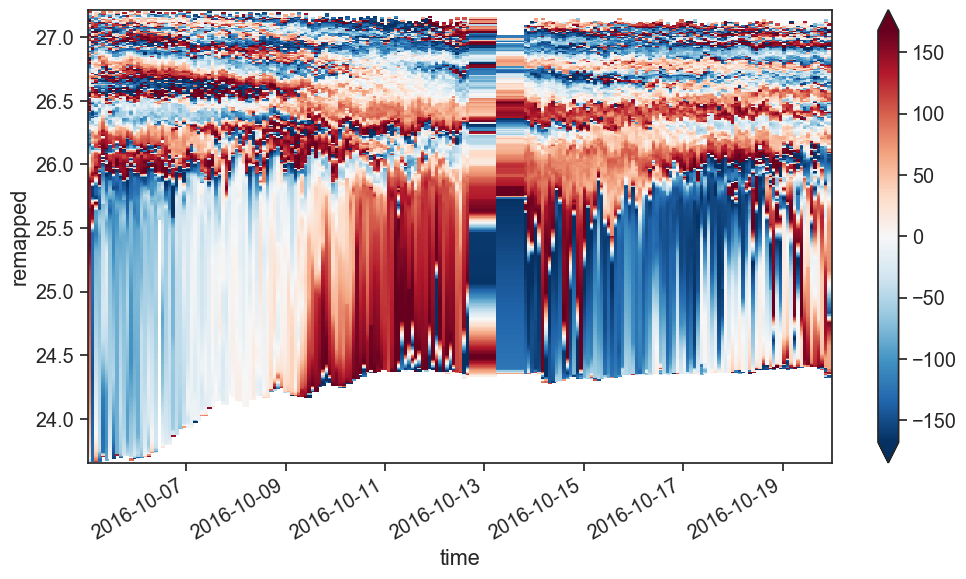

In [1434]:
shear_angle_remap = linear_interpolation_remap(raw.z, raw.angS_br0, sigma_coords)
shear_angle_remap.plot(x='time', robust=True)

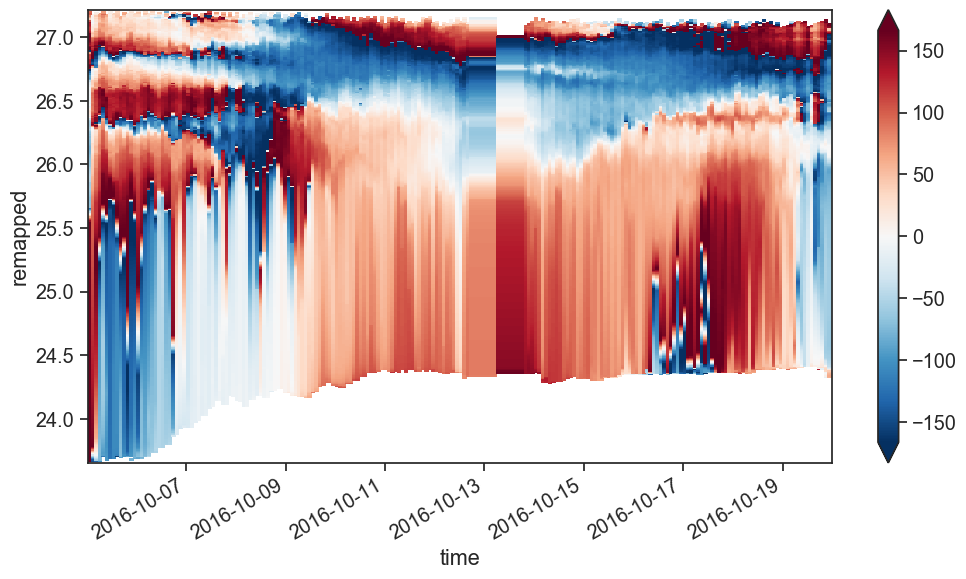

In [1435]:
vel_angle_remap = linear_interpolation_remap(raw.z, raw.ang_br0, sigma_coords)
vel_angle_remap.plot(x='time', robust=True)

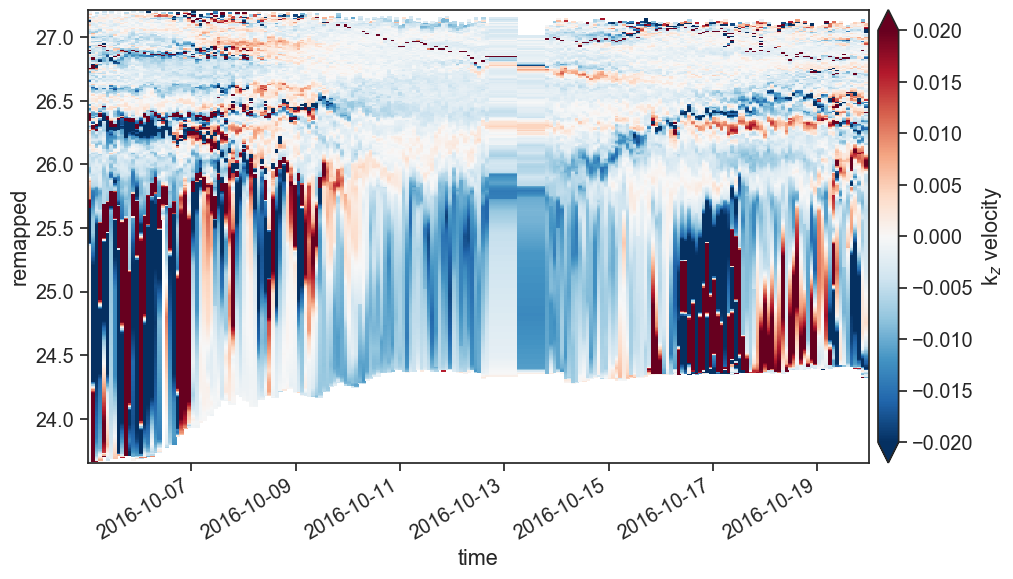

In [1436]:
vel_angle_remap = linear_interpolation_remap(raw.z, raw.kz_vel, sigma_coords)
vel_angle_remap.plot(x='time', vmin=-0.02, vmax=0.02, robust=True, cmap='RdBu_r',
                    cbar_kwargs={'pad':0.01,'label':r'k$_z$ velocity'})

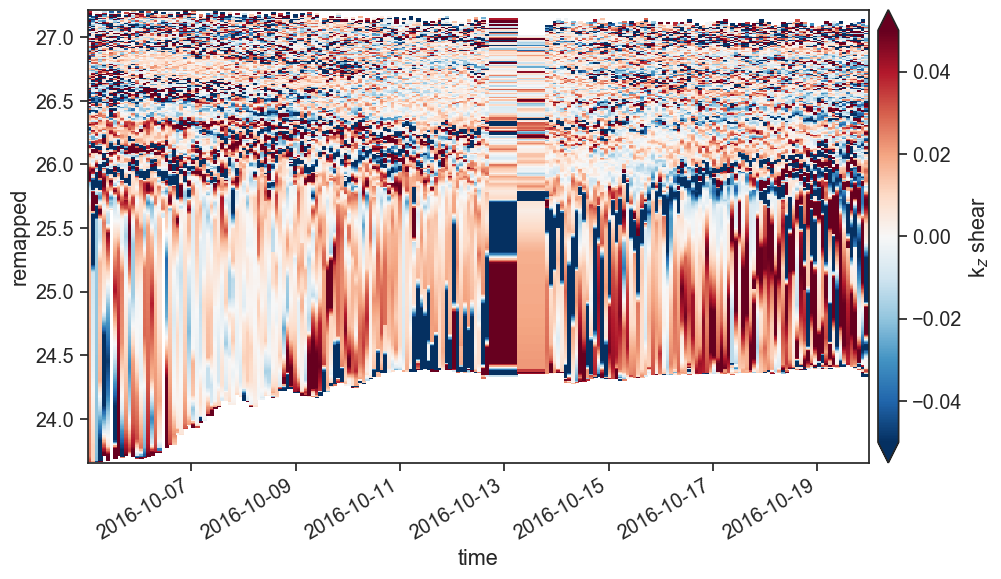

In [1437]:
vel_angle_remap = linear_interpolation_remap(raw.z, raw.kz_shear, sigma_coords)
vel_angle_remap.plot(x='time', vmin=-0.05, vmax=0.05, cmap='RdBu_r',
                    cbar_kwargs={'pad':0.01,'label':r'k$_z$ shear'})